## Code for Cplex formulation of Alstom problem

In [41]:
import math
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.basic import Expr
from docplex.mp.model import Model
from docplex.mp.solution import SolveSolution
from docplex.util.status import JobSolveStatus
import cplex.callbacks as cpx_cb

## Approximating the functions with polynomials

### RAV function

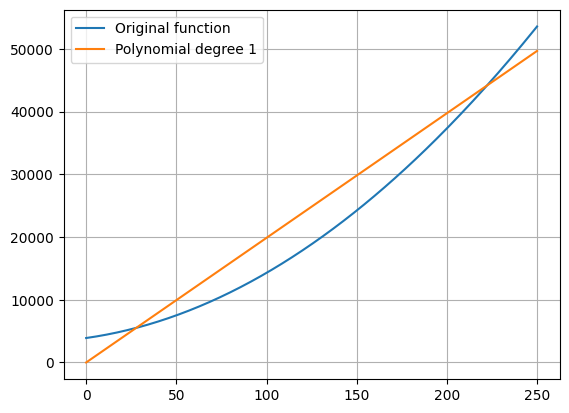

In [42]:
A, B, C, m, v_max, p_max, c_max = 3900, 40.7, 0.632, 400000, 220, 4305220, 320000
import numpy as np


def P(v):
    return (A + B * v + C * v**2)


a, b = 0, 250
n = 1

# Choose n+1 interpolation points
x_points = np.linspace(a, b, 220)
y_points_bis = []
for x in x_points:
    y_points_bis.append(P(x))

# Get the polynomial coefficients (highest degree first)
coeffs = np.polyfit(x_points, y_points_bis, deg=n)
coeffs[1] = 0
# Create polynomial function
Prav_poly = np.poly1d(coeffs)


def Prav(v):
    return Prav_poly(v)
# Remove RAV to simplify the problem
'''def Prav(v):
    return 0'''

y_points_approx = []
for i in range(len(x_points)):
    y_points_approx.append(Prav(x_points[i]))


if __name__ == "__main__":
    plt.plot(x_points, y_points_bis, label="Original function")
    plt.plot(x_points, y_points_approx, label=f"Polynomial degree {n}")
    plt.legend()
    plt.grid(True)
    plt.show()

### Traction

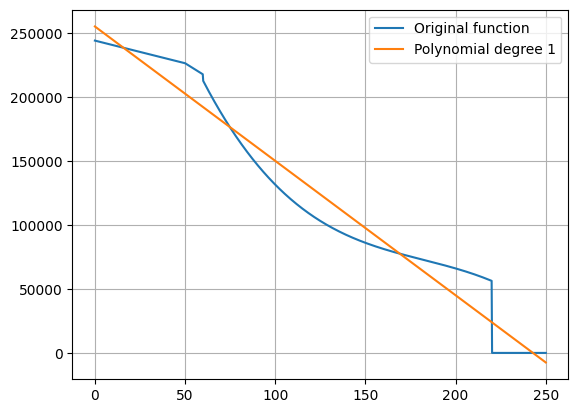

In [43]:
def f(v):
    if 0 <= v <= 50:
        return -354.1 * v + 2.44 * (10**5)
    elif 50 <= v < 60:
        return -881.3 * v + 2.704 * (10**5)
    elif 60 <= v < 220:
        return -0.05265 * (v**3) + 28.78 * (v**2) - 5603 * v + 4.566 * (10**5)
    else:
        return 0
    
a, b = 0, 250
n = 1

# Choose n+1 interpolation points
x_points = np.linspace(a, b, 1000)
y_points_bis = []
for x in x_points:
    y_points_bis.append(f(x))

# Get the polynomial coefficients (highest degree first)
coeffs = np.polyfit(x_points, y_points_bis, deg=n)

# Create polynomial function
Ptraction = np.poly1d(coeffs)


y_points_approx = []
for i in range(len(x_points)):
    y_points_approx.append(Ptraction(x_points[i]))

F_pos_max = max(y_points_approx)

if __name__ == "__main__":
    plt.plot(x_points, y_points_bis, label="Original function")
    plt.plot(x_points, y_points_approx, label=f"Polynomial degree {n}")
    plt.legend()
    plt.grid(True)
    plt.show()

### Braking

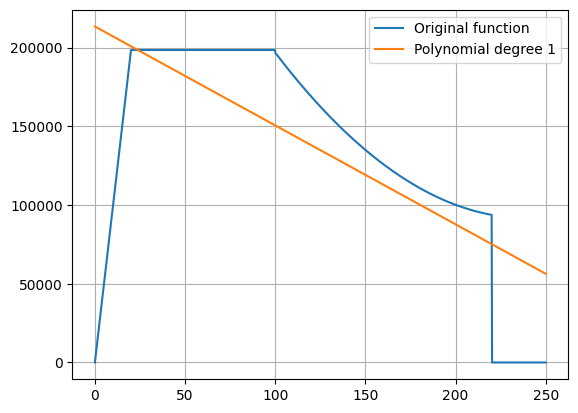

In [44]:
def f(v):
    if 0 <= v <= 20:
        return 9925 * v + 1.243
    if 20 <= v <= 100:
        return 2.039 * (10**-13) * v + 1.985 * (10**5)
    if 100 <= v <= 220:
        return 5.389 * (v**2) - 2583 * v + 4.012 * (10**5)
    else:
        return 0


# Interval [a, b] and degree n
a, b = 0, 250
n = 1

# Choose n+1 interpolation points
x_points = np.linspace(a, b, 1000)
y_points_bis = []
for x in x_points:
    y_points_bis.append(f(x))

# Get the polynomial coefficients (highest degree first)
coeffs = np.polyfit(x_points, y_points_bis, deg=n)

# Create polynomial function
Pbraking = np.poly1d(coeffs)



y_points_approx = []
for i in range(len(x_points)):
    y_points_approx.append(Pbraking(x_points[i]))

F_neg_max = max(y_points_approx)
F_max = max(F_pos_max, F_neg_max)

if __name__ == "__main__":
    plt.plot(x_points, y_points_bis, label="Original function")
    plt.plot(x_points, y_points_approx, label=f"Polynomial degree {n}")
    plt.legend()
    plt.grid(True)
    plt.show()

### Power usage

[-1.91022402e-16  7.13384433e-01  0.00000000e+00  2.46745051e-02]
The polynomial is: -1.9102240217704484e-16 + 0.7133844326799073*x + 0.0*y + 0.024674505091040418*x*y


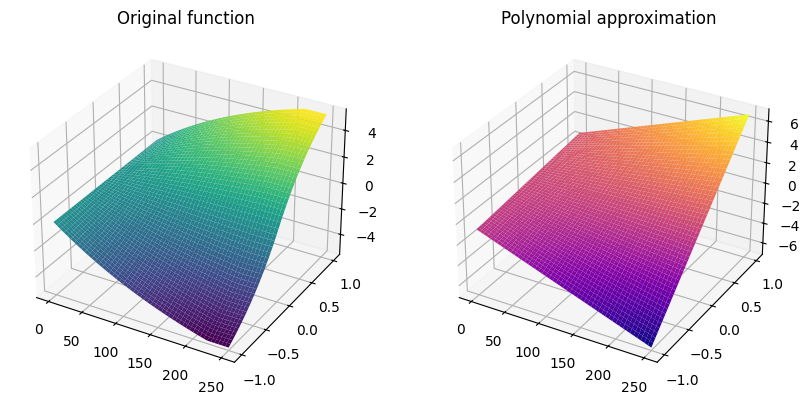

In [45]:
def cost(V, demand):
    F_max = 1
    V_max = 220
    F = demand
    p_max = 4305220
    c_max = 320000
    V_safe = min(V, V_max)
    # Ensure V is within a safe range for math.exp
    c = (
        (1 - math.exp(-V_safe / (V_max + 0.001)))
        * math.tanh(100 * F)
        * (1 - math.exp(-abs(F) / (F_max + 0.001)))
    )
    Puti = (c / c_max) * p_max
    # For now we ignore regen braking
    '''if Puti < 0:
        Puti = 0
    elif Puti > p_max:
        Puti = p_max'''
    return Puti


# Define the domain
a_x, b_x = 0, 250
a_y, b_y = -1, 1
n = 1  # degree in x
l = 1  # degree in y

# Create the interpolation points (equally spaced)
x_points = np.linspace(a_x, b_x, 1000)
y_points = np.linspace(a_y, b_y, 1000)
X, Y = np.meshgrid(x_points, y_points, indexing="ij")
Z = np.eye(1000)
for i in range(len(x_points)):
    for j in range(len(y_points)):
        x = x_points[i]
        y = y_points[j]
        Z[i, j] = cost(x, y)


# Build the Vandermonde matrix for 2D
x_flat = X.ravel()
y_flat = Y.ravel()

A = np.vstack([(x_flat**i) * (y_flat**j) for i in range(n + 1) for j in range(l + 1)]).T

b = Z.ravel()
coeffs_pow, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
print(coeffs_pow)
print(f"The polynomial is: {coeffs_pow[0]} + {coeffs_pow[1]}*x + {coeffs_pow[2]}*y + {coeffs_pow[3]}*x*y")


# Define the polynomial function
def Ppower(x, y):
    val = 0
    idx = 0
    for i in range(n + 1):
        for j in range(l + 1):
            val += coeffs_pow[idx] * (x**i) * (y**j)
            idx += 1
    return val


# Evaluation grid
x_eval = x_points
y_eval = y_points
X_eval, Y_eval = np.meshgrid(x_eval, y_eval, indexing="ij")
Z_eval = Ppower(X_eval, Y_eval)

# Plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection="3d")
ax.plot_surface(X_eval, Y_eval, Z, cmap="viridis")
ax.set_title("Original function")

ax2 = fig.add_subplot(122, projection="3d")
ax2.plot_surface(X_eval, Y_eval, Z_eval, cmap="plasma")
ax2.set_title("Polynomial approximation")

plt.show()

Text(0.5, 1.0, 'Max acceleration at constant power vs Speed')

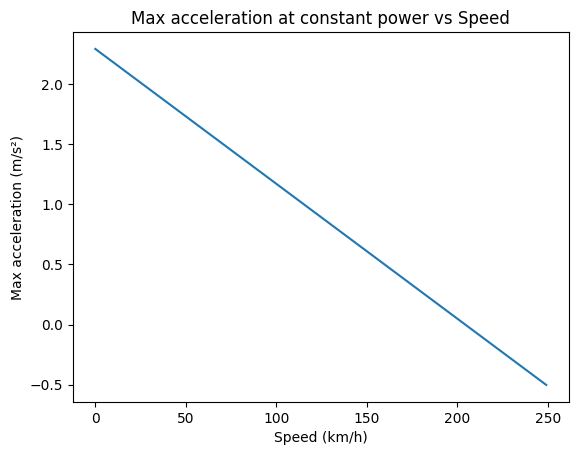

In [46]:
# Testing speed at constant maximum power
v = np.arange(0, 250, 1)
max_acceration = []
for speed in v:
    max_acceration.append((Ptraction(speed)-Prav_poly(speed))*3.6 / m)


plt.plot(v, max_acceration, label="Max acceleration at constant power")
plt.xlabel("Speed (km/h)")
plt.ylabel("Max acceleration (m/s²)")
plt.title("Max acceleration at constant power vs Speed")

## Defining the Model

### Define model

In [47]:
opt_model = Model(name="Poly_Model")
N = 10
Dist = 15

### Define variables

In [48]:
v={}
for i in range(0, N):
    v[i]= opt_model.continuous_var(name=f"v_{i}",lb=0, ub=v_max)

d={}
for i in range(0, N):
    d[i]= opt_model.continuous_var(name=f"d_{i}",lb=0, ub=2)

### Cost function

#### Linearization

In [49]:
# We need to linearize the d*v part of the polynomial
# Using McCormick envelopes

w1 = {}
for i in range(0, N):
    w1[i] = opt_model.continuous_var(name=f"w1_{i}",lb=0,ub=v_max)

V_min, V_max = 0, 250
d_min, d_max = -1, 1

# coefficients from polynomial fit
c0, c1, c2, c3 = coeffs_pow

for i in range(0, N):
    opt_model.add_constraint(w1[i] >= V_min * (d[i]-1) + v[i] * d_min - V_min * d_min)
    opt_model.add_constraint(w1[i] >= V_max * (d[i]-1) + v[i] * d_max - V_max * d_max)
    opt_model.add_constraint(w1[i] <= V_max * (d[i]-1) + v[i] * d_min - V_max * d_min)
    opt_model.add_constraint(w1[i] <= V_min * (d[i]-1) + v[i] * d_max - V_min * d_max)

#### Definition

In [50]:
# Total cost
total_cost = opt_model.sum(c0 + c1 * v[i] + c2 * (d[i]-1) + c3 * w1[i] for i in range(N))
opt_model.minimize(total_cost)

### Speed phyics constraints

#### Linearising

In [51]:
# We linearize the logical function d>0 -> F_+ ...
kroe={}
for i in range(0, N):
    kroe[i]= opt_model.binary_var(name=f"kroe_{i}")

Big_M = 3
epsilon = 1e-6

# Constraint: if delta == 1, then d >= epsilon
for i in range(0, N):
    opt_model.add_constraint((d[i]-1) >= epsilon - Big_M * (1 - kroe[i]))

    # Constraint: if delta == 0, then d <= 0
    opt_model.add_constraint((d[i]-1) <= -epsilon + Big_M * kroe[i])

    


In [52]:
#Linearization 1 to linearize (1-kroe)*F_braking and kroe*F_traction
z1={}
z2={}
for i in range(0, N):
    z1[i]= opt_model.continuous_var(name=f"z1_{i}",lb=0,ub=F_max)
    z2[i]= opt_model.continuous_var(name=f"z2_{i}",lb=0,ub=F_max)

# z1 = kroe * F+ = x*y where y in [0,F_max]
# z2 = (1 - kroe) * F- = x*y where y in [0,F_max]

L1 = 0.0
L2 = 0.0
U1 = F_max
U2 = F_max


for i in range(0, N):
    opt_model.add_constraint(z1[i] <= kroe[i]*F_max)
    opt_model.add_constraint(z2[i] <= (1 - kroe[i]) * F_max)
    opt_model.add_constraint(z1[i] >= L1 * kroe[i])
    opt_model.add_constraint(z2[i] >= L2 * (1 - kroe[i]))
    opt_model.add_constraint(z1[i] <= Ptraction(v[i]) -L1*(1 - kroe[i]))
    opt_model.add_constraint(z2[i] <= Pbraking(v[i]) + L2 * kroe[i])
    opt_model.add_constraint(z1[i] >= Ptraction(v[i]) - U1 * (1 - kroe[i]))
    opt_model.add_constraint(z2[i] >= Pbraking(v[i]) + U2 * kroe[i])


In [53]:
# Linearization 2 to linearize d*(z1+z2) using McCormick envelopes

w2 = {}
for i in range(0, N):
    w2[i] = opt_model.continuous_var(name=f"w2_{i}",lb=0,ub=2*F_max)

dL, dU = -1, 1
zL, zU = 0, F_max

for i in range(0, N):
    zsum = z1[i] + z2[i]
    opt_model.add_constraint(w2[i] >= dL * zsum + zL * (d[i]-1) - dL * zL)
    opt_model.add_constraint(w2[i] >= dU * zsum + zU * (d[i]-1) - dU * zU)
    opt_model.add_constraint(w2[i] <= dU * zsum + zL * (d[i]-1) - dU * zL)
    opt_model.add_constraint(w2[i] <= dL * zsum + zU * (d[i]-1) - dL * zU)
    


#### Definition

In [54]:
Big_M_force = 10e6
epsilon_acc = 1e-6

for i in range(1,N-2):
    # I multiply by 3.6 to convert from m/s^2 to km/h/s
    opt_model.add_constraint(
    v[i+1] == v[i] + 3.6 * (1/m) * (w2[i]-Prav(v[i])),
    f"Velocity constraint {i}"
)
    # Testing additional constraints to ensure w2-kroe correlation
    '''opt_model.add_constraint(
        w2[i] - Prav(v[i]) <= -epsilon_acc + Big_M_force * kroe[i],
        f"No acceleration unless d>1 at {i}"
    )'''
    opt_model.add_constraint(w2[i] - Prav(v[i]) <= Big_M * kroe[i])
    '''opt_model.add_constraint(w2[i] - Prav(v[i]) >= -Big_M * (1 - kroe[i]))'''

    


In [55]:
# Additional constraints for speed
opt_model.add_constraint(v[0] == 0, "Initial velocity")
opt_model.add_constraint(v[N-1] == 0, "Final velocity")

for i in range(0, N):
    opt_model.add_constraint(v[i]>= 0, f"Velocity non-negativity {i}")
    opt_model.add_constraint(v[i] <= v_max, f"Velocity upper bound {i}")

## Distance constraints

In [56]:
Distance = 0
for i in range(0, N):
    Distance += v[i]

opt_model.add_constraint(Distance >= Dist, "Total distance constraint")

docplex.mp.LinearConstraint[Total distance constraint](v_0+v_1+v_2+v_3+v_4+v_5+v_6+v_7+v_8+v_9,GE,15)

## Problem Verification

In [57]:
opt_model.print_information() 

print(opt_model.prettyprint())    

Model: Poly_Model
 - number of variables: 70
   - binary=10, integer=0, continuous=60
 - number of constraints: 217
   - linear=217
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
// This file has been generated by DOcplex
// model name is: Poly_Model
// single vars section
dvar float v_0;
dvar float v_1;
dvar float v_2;
dvar float v_3;
dvar float v_4;
dvar float v_5;
dvar float v_6;
dvar float v_7;
dvar float v_8;
dvar float v_9;
dvar float d_0;
dvar float d_1;
dvar float d_2;
dvar float d_3;
dvar float d_4;
dvar float d_5;
dvar float d_6;
dvar float d_7;
dvar float d_8;
dvar float d_9;
dvar float w1_0;
dvar float w1_1;
dvar float w1_2;
dvar float w1_3;
dvar float w1_4;
dvar float w1_5;
dvar float w1_6;
dvar float w1_7;
dvar float w1_8;
dvar float w1_9;
dvar bool kroe_0;
dvar bool kroe_1;
dvar bool kroe_2;
dvar bool kroe_3;
dvar bool kroe_4;
dvar bool kroe_5;
dvar bool kroe_6;
dvar bool kroe_7;
dvar bool kroe_8;
dvar bool kroe_9;
dvar float z1_0;
dvar float z2_

## Solving

In [58]:
opt_model.parameters.timelimit = 60  # Set a time limit (seconds)
opt_model.parameters.mip.tolerances.mipgap = 1e-6  # Acceptable optimality gap
opt_model.parameters.mip.tolerances.integrality = 1e-12  # Integrality tolerance
result = opt_model.solve(log_output=True)
if result:
    v_sol = [result.get_value(v[i]) for i in range(N)]
    d_sol = [result.get_value(d[i])-1 for i in range(N)]
    kroe_sol = [result.get_value(kroe[i]) for i in range(N)]
    print("Solution found")
else:
    print("No solution found.")

Dists = []
for i in range(0, N):
    Dists.append(sum(v_sol[:i]))

Version identifier: 22.1.2.0 | 2024-12-09 | 8bd2200c8
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               60
CPXPARAM_MIP_Tolerances_MIPGap                   9.9999999999999995e-07
CPXPARAM_MIP_Tolerances_Integrality              9.9999999999999998e-13
Tried aggregator 2 times.
MIP Presolve eliminated 195 rows and 48 columns.
MIP Presolve modified 10 coefficients.
Aggregator did 8 substitutions.
Reduced MIP has 14 rows, 14 columns, and 40 nonzeros.
Reduced MIP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.18 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 14 rows, 14 columns, and 40 nonzeros.
Reduced MIP has 0 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.02 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 20 threads.
Root relaxation solution time = 0.00 sec. (0.02

## Visualization

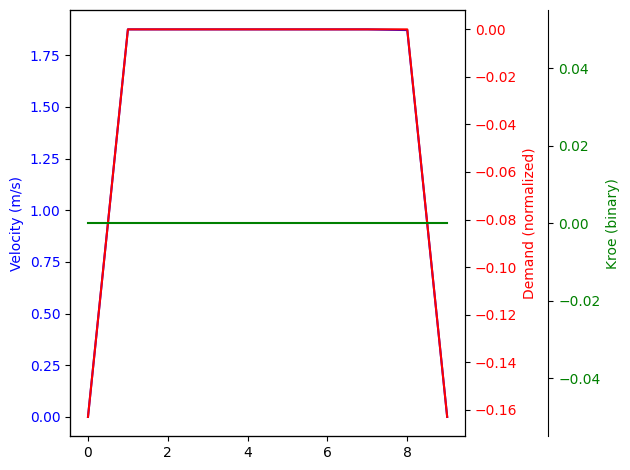

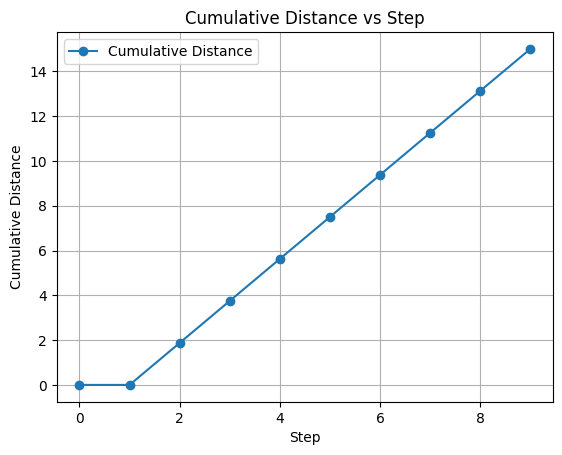

In [59]:
fig, ax1 = plt.subplots()

ax1.plot(v_sol, 'b-', label='Velocity (m/s)')
ax1.set_ylabel('Velocity (m/s)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(d_sol, 'r-', label='Demand (normalized)')
ax2.set_ylabel('Demand (normalized)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(kroe_sol, 'g-', label='Kroe (binary)')
ax3.set_ylabel('Kroe (binary)', color='g')
ax3.tick_params(axis='y', labelcolor='g')

fig.tight_layout()
plt.show()

# Plot Dists vs index
plt.figure()
plt.plot(Dists, marker='o', label='Cumulative Distance')
plt.xlabel('Step')
plt.ylabel('Cumulative Distance')
plt.title('Cumulative Distance vs Step')
plt.grid(True)
plt.legend()
plt.show()

In [60]:
print(v_sol)
print(d_sol)
print(kroe_sol)

[0, 1.8754192265253493, 1.8754192265253493, 1.8754192265253493, 1.8754192265253493, 1.8754192265253493, 1.875419226525349, 1.875419226525349, 1.872065414322554, 0]
[-0.16304907280391778, -1.0000000000287557e-06, -1.0000000000287557e-06, -1.0000000000287557e-06, -1.0000000000287557e-06, -1.0000000000287557e-06, -1.0000000000287557e-06, -1.0000000000287557e-06, -1.0000000000287557e-06, -0.16304907280391778]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
